In [431]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import random 

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchinfo import summary
import pandas as pd
import os

from tqdm import trange
import inspect
import time
%matplotlib inline

from myUtils import *
from plottingUtils import *

In [432]:
#hyperparameters

data_dir = "./datasets/PJM_power/"
fname = "DAYTON_hourly.csv"

sample_len = 120
step = 1
target_len = 120
batch_size = 64
steps_in_day = 24

HID_DIM = 256
N_LAYERS = 4
DROPOUT = 0.5
N_PARAMS = 2*50

desired_features = None

In [433]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
print(torch.__version__)

Using cuda device
2.0.1+cu117


In [434]:
def apply_vals(vals, seq):
    '''
    vals: [batch size, n_features, n_params]
    
    '''
    batch_size = vals.shape[0]
    n_features = vals.shape[1]
    vals = vals.unsqueeze(3)
    #print("vals", vals.shape, vals.device)
    seq = seq.unsqueeze(0).unsqueeze(1).repeat(batch_size, n_features, 1).float()
    #print("seq", seq.shape, seq.device)
    #print("x0", vals[:,:,0].shape)
    #print("a", vals[:,:,2::2].shape)
    x = vals[:,:, 2::2] + torch.matmul(vals[:,:, 3::2], seq.unsqueeze(2))
    out = vals[:,:,0] + vals[:,:,1] * seq + torch.sin(x).sum(2)
    #print("out", out.shape)
    return out.permute(0, 2, 1)


In [435]:
class Fourier(nn.Module):
    def __init__(self, n_features, hid_dim, n_layers, n_params, dropout, device):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.device = device

        self.rnn = nn.GRU(
            input_size=n_features,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True,
        )

        self.fc = nn.Linear(hid_dim * n_layers, n_params * n_features)

    def forward(self, src):
        # src = [batch size, src len, n features]
        #print("src", src.shape)
        batch_size = src.shape[0]
        n_features = src.shape[2]
        
        _, hidden = self.rnn(src)
        #hidden = [n layers, batch size, hid dim]
        hidden = hidden.permute(1, 0, 2).reshape(batch_size, -1).contiguous()
        #hidden = [batch size, n layers * hid dim]
        output = self.fc(hidden)
        #output = [batch size, n params * n features]
        return output.reshape(batch_size, n_features, -1)

In [436]:
# model fitting



def train(
    dataloader,
    model,
    loss_fn,
    optimizer,
    iter_count=None,
    visibility=True,
):
    """
    dataloader: iterable
    model: model to train
    loss_fn: loss function
    optimizer: used optimizer
    iter_count: number of iterations, if None then dataloader length
    desired_features: list of features to be used in loss calculation, if None then all features
    teacher_forcing_ratio: probability to use teacher forcing
    visibility: boolean, if True then show progress bar
    """
    assert not (
        inspect.isgenerator(dataloader) and iter_count is None
    ), "generator must have specified size"
    if iter_count is None:
        iter_count = len(dataloader.dataset)

    data_iterator = iter(dataloader)
    model.train()
    average_loss = 0

    r = trange(iter_count) if visibility else range(iter_count)

    for _ in r:
        x, y = next(data_iterator)
        x, y = x.to(device), y.to(device)
        # y = y.unsqueeze(1).to(torch.float)
        # Compute prediction error

        pred = model(x)
        value = apply_vals(pred, torch.arange(y.shape[1]).to(device))
        
        loss = loss_fn(value, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        average_loss += loss.item()

    average_loss /= iter_count

    return average_loss


def eval(
    dataloader, 
    model, 
    loss_fn, 
    iter_count=None, 
    visibility=True
):
    """
    dataloader: iterable
    model: model to train
    loss_fn: loss function
    iter_count: number of iterations, if None then dataloader length
    desired_features: list of features to be used in loss calculation
    visibility: boolean, if True then show progress bar
    """
    if iter_count is None:
        iter_count = len(dataloader.dataset)
    data_iterator = iter(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        r = trange(iter_count) if visibility else range(iter_count)
        for _ in r:
            x, y = next(data_iterator)
            x, y = x.to(device), y.to(device)
            # y = y.unsqueeze(1).to(torch.float)
            pred = model(x)
            value = apply_vals(pred, torch.arange(y.shape[1]).to(device))

            test_loss += loss_fn(value, y).item()

    test_loss /= iter_count

    return test_loss


def fit_model(
    model,
    train_dataloader,
    val_dataloader,
    loss_fn,
    optimizer,
    epochs=5,
    train_iter_count=None,
    val_iter_count=None,
    visibility = 0,
    save_model = False
):
    '''
    model: model to train
    train_dataloader: iterable
    val_dataloader: iterable
    loss_fn: loss function
    optimizer: used optimizer
    epochs: number of epochs
    train_iter_count: number of training iterations
    val_iter_count: number of validation iterations
    desired_features: list of features to be used in loss calculation
    teacher_forcing_ratio: probability to use teacher forcing
    visibility: 0 - no progress bar, 1 - progress bar for entire training, 2 - progress bar for each epoch
    save_model: boolean, if True then save model with lowest validation loss
    '''
    history = {
        "train": {"loss": []},
        "val": {"loss": []},
    }
    total_time_start = time.time()
    r = trange(epochs) if visibility == 1 else range(epochs)

    min_val_loss = np.inf

    for t in r:
        if visibility == 2:
            print(f"Epoch {t+1}\n-------------------------------")
            print("Test")
        train_loss = train(
            train_dataloader,
            model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            iter_count=train_iter_count,
            visibility=(visibility == 2),
        )
        if visibility == 2:
            print("Eval")
        test_loss = eval(
            val_dataloader,
            model,
            loss_fn=loss_fn,
            iter_count=val_iter_count,
            visibility=(visibility == 2),
        )

        if min_val_loss > test_loss and save_model:
            min_val_loss = test_loss
            torch.save(model, "model.pth")
        if visibility == 2:
            print(f"Train Error: Avg loss: {train_loss:>8f} ")
            print(f"Test Error: Avg loss: {test_loss:>8f} \n")
        history["train"]["loss"].append(train_loss)
        history["val"]["loss"].append(test_loss)

    total_time_end = time.time()
    total_duration = total_time_end - total_time_start
    
    average_duration = total_duration / epochs
    if visibility != 0:
        print(f"Total Duration: {print_duration(total_duration)}")
        print(f"Average Duration: {print_duration(average_duration)}")

    
    return history

In [437]:
# preprocessing


df = extract_dataframe(data_dir, fname)
#df = add_features(df, steps_in_day=steps_in_day)

header, float_data = extract_data(df)
normalized_data, mean, std = normalize_data(float_data)

In [438]:
timesteps = len(float_data)
print(f'{timesteps} timesteps')

121275 timesteps


In [439]:

train_max_index = int(timesteps * 0.7)

train_generator = floating_window_batch_generator(
    normalized_data,
    sample_len=sample_len,
    target_len=target_len,
    min_index=0,
    max_index=train_max_index,
    shuffle=True,
    step=step,
    batch_size=batch_size,
    
)

val_generator = floating_window_batch_generator(
    normalized_data,
    sample_len=sample_len,
    target_len=target_len,
    min_index=train_max_index+1,
    max_index=timesteps,
    shuffle=True,
    step=step,
    batch_size=batch_size
)



DAYTON_MW


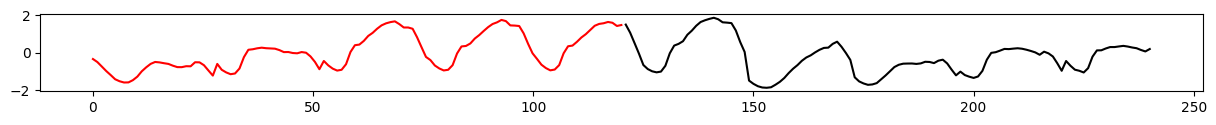

In [440]:
samples, targets = next(train_generator)
for feature in range(samples.shape[-1]):
    print(header[feature])
    plot_samples(samples, targets, feature, figsize=(15,1))

In [441]:

N_SAMPLES = float_data.shape[1]

model = Fourier(N_SAMPLES, HID_DIM, N_LAYERS, N_PARAMS, DROPOUT, device).to(device)
#model = Iterative(N_SAMPLES, HID_DIM, N_LAYERS, DROPOUT).to(device)
print(model)

Fourier(
  (rnn): GRU(1, 256, num_layers=4, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=1024, out_features=100, bias=True)
)


In [442]:


summary(model,input_size=(10, sample_len, N_SAMPLES),col_names=["input_size", "output_size", "num_params", "trainable", "kernel_size"], col_width=15,)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Trainable       Kernel Shape
Fourier                                  [10, 120, 1]    [10, 1, 100]    --              True            --
├─GRU: 1-1                               [10, 120, 1]    [10, 120, 256]  1,383,168       True            --
├─Linear: 1-2                            [10, 1024]      [10, 100]       102,500         True            --
Total params: 1,485,668
Trainable params: 1,485,668
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.66
Input size (MB): 0.00
Forward/backward pass size (MB): 2.47
Params size (MB): 5.94
Estimated Total Size (MB): 8.41

In [443]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,485,668 trainable parameters


In [444]:
# Fit model

loss_fn = nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = fit_model(
    model,
    train_dataloader=train_generator,
    train_iter_count=100,
    val_dataloader=val_generator,
    val_iter_count=50,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=20,
    save_model=True,
    visibility=2
)

Epoch 1
-------------------------------
Test


100%|██████████| 100/100 [00:06<00:00, 16.63it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 36.10it/s]


Train Error: Avg loss: 18.580629 
Test Error: Avg loss: 6.230244 

Epoch 2
-------------------------------
Test


100%|██████████| 100/100 [00:05<00:00, 19.53it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 39.50it/s]


Train Error: Avg loss: 5.395106 
Test Error: Avg loss: 1.773030 

Epoch 3
-------------------------------
Test


100%|██████████| 100/100 [00:04<00:00, 20.40it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 39.29it/s]


Train Error: Avg loss: 2.360158 
Test Error: Avg loss: 0.963878 

Epoch 4
-------------------------------
Test


100%|██████████| 100/100 [00:04<00:00, 20.49it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 39.68it/s]


Train Error: Avg loss: 1.388805 
Test Error: Avg loss: 0.806408 

Epoch 5
-------------------------------
Test


100%|██████████| 100/100 [00:04<00:00, 20.44it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 39.54it/s]


Train Error: Avg loss: 1.137945 
Test Error: Avg loss: 0.810469 

Epoch 6
-------------------------------
Test


100%|██████████| 100/100 [00:04<00:00, 20.20it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 39.29it/s]


Train Error: Avg loss: 1.095662 
Test Error: Avg loss: 1.045802 

Epoch 7
-------------------------------
Test


100%|██████████| 100/100 [00:05<00:00, 19.00it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 40.16it/s]


Train Error: Avg loss: 1.304931 
Test Error: Avg loss: 0.896242 

Epoch 8
-------------------------------
Test


100%|██████████| 100/100 [00:05<00:00, 19.30it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 34.28it/s]


Train Error: Avg loss: 2.870022 
Test Error: Avg loss: 21.092435 

Epoch 9
-------------------------------
Test


100%|██████████| 100/100 [00:05<00:00, 17.69it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 38.23it/s]


Train Error: Avg loss: 24.334649 
Test Error: Avg loss: 5.549029 

Epoch 10
-------------------------------
Test


100%|██████████| 100/100 [00:05<00:00, 19.39it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 33.52it/s]


Train Error: Avg loss: 2.823300 
Test Error: Avg loss: 0.845234 

Epoch 11
-------------------------------
Test


100%|██████████| 100/100 [00:05<00:00, 18.42it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 35.30it/s]


Train Error: Avg loss: 1.199137 
Test Error: Avg loss: 0.842959 

Epoch 12
-------------------------------
Test


100%|██████████| 100/100 [00:05<00:00, 19.61it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 35.25it/s]


Train Error: Avg loss: 1.078417 
Test Error: Avg loss: 0.818157 

Epoch 13
-------------------------------
Test


100%|██████████| 100/100 [00:05<00:00, 18.59it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 33.61it/s]


Train Error: Avg loss: 0.955722 
Test Error: Avg loss: 0.788739 

Epoch 14
-------------------------------
Test


100%|██████████| 100/100 [00:05<00:00, 18.18it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 35.19it/s]


Train Error: Avg loss: 0.915164 
Test Error: Avg loss: 0.731698 

Epoch 15
-------------------------------
Test


100%|██████████| 100/100 [00:05<00:00, 19.39it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 38.31it/s]


Train Error: Avg loss: 0.888818 
Test Error: Avg loss: 0.726081 

Epoch 16
-------------------------------
Test


100%|██████████| 100/100 [00:05<00:00, 19.03it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 34.11it/s]


Train Error: Avg loss: 0.829006 
Test Error: Avg loss: 0.689167 

Epoch 17
-------------------------------
Test


100%|██████████| 100/100 [00:05<00:00, 18.58it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 36.21it/s]


Train Error: Avg loss: 0.817659 
Test Error: Avg loss: 0.721284 

Epoch 18
-------------------------------
Test


100%|██████████| 100/100 [00:05<00:00, 18.59it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 35.92it/s]


Train Error: Avg loss: 0.827045 
Test Error: Avg loss: 0.788338 

Epoch 19
-------------------------------
Test


100%|██████████| 100/100 [00:05<00:00, 18.36it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 35.44it/s]


Train Error: Avg loss: 0.812996 
Test Error: Avg loss: 0.746347 

Epoch 20
-------------------------------
Test


100%|██████████| 100/100 [00:04<00:00, 20.18it/s]


Eval


100%|██████████| 50/50 [00:01<00:00, 38.17it/s]

Train Error: Avg loss: 0.810543 
Test Error: Avg loss: 0.719648 

Total Duration: 0:2:12.484
Average Duration: 0:0:6.624


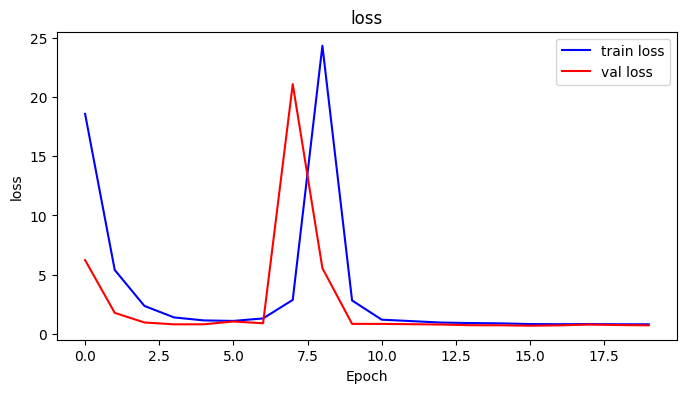

In [445]:
plot_history(history)

In [446]:


def make_predictions(model, samples, len):
    with torch.no_grad():
        values = model(samples.to(device))
        output = apply_vals(values, torch.arange(len).to(device))
    return output





torch.Size([64, 120, 1])
DAYTON_MW


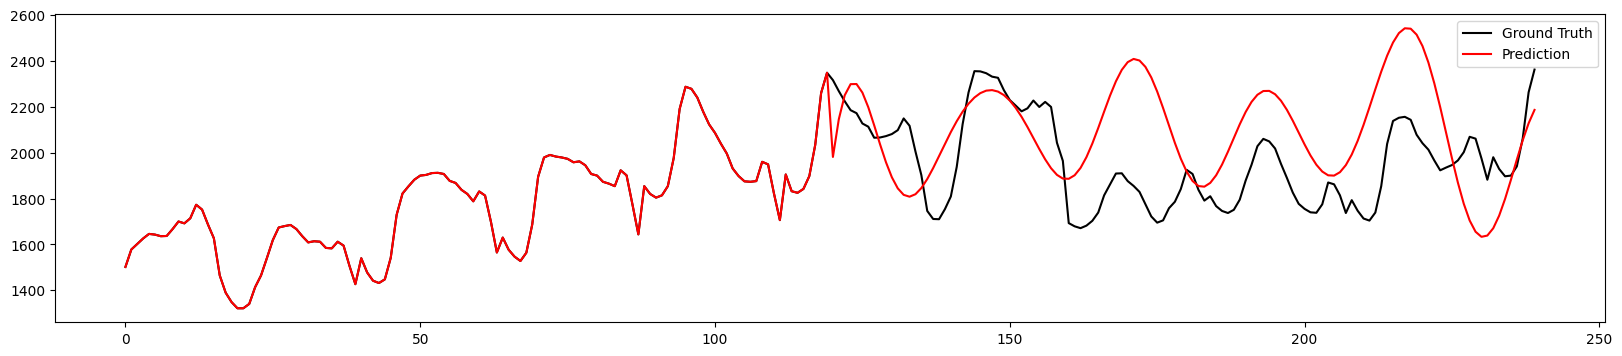

torch.Size([64, 120, 1])
DAYTON_MW


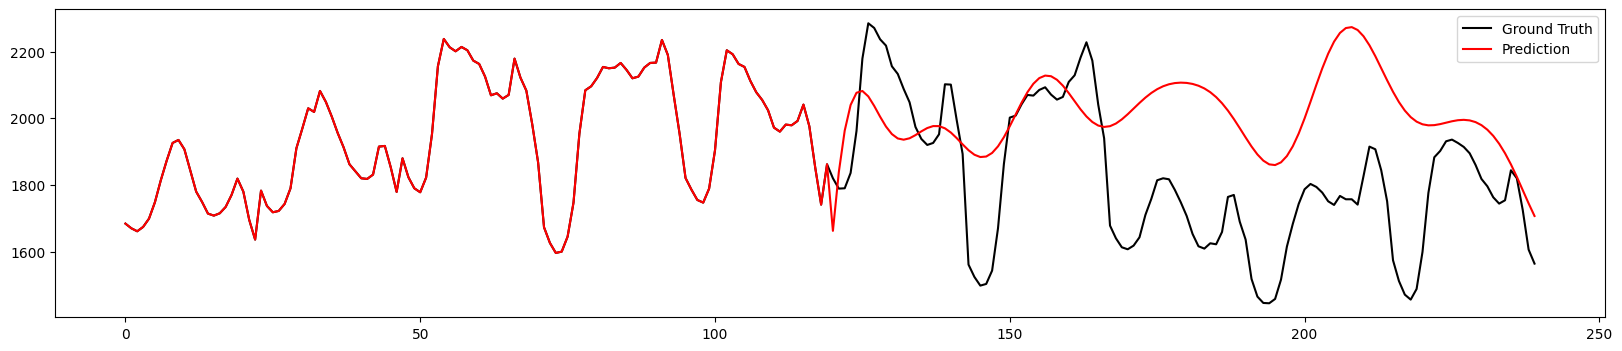

torch.Size([64, 120, 1])
DAYTON_MW


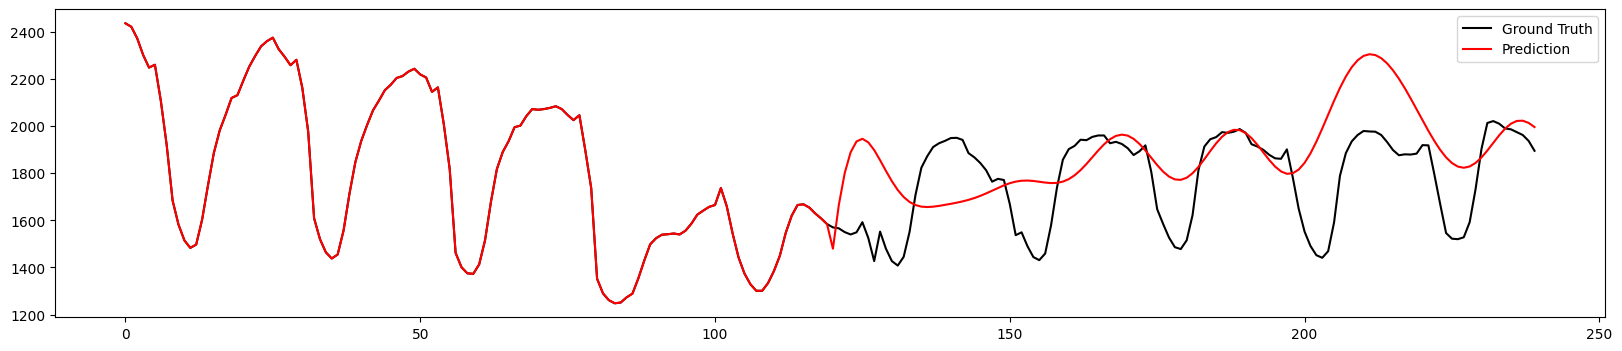

torch.Size([64, 120, 1])
DAYTON_MW


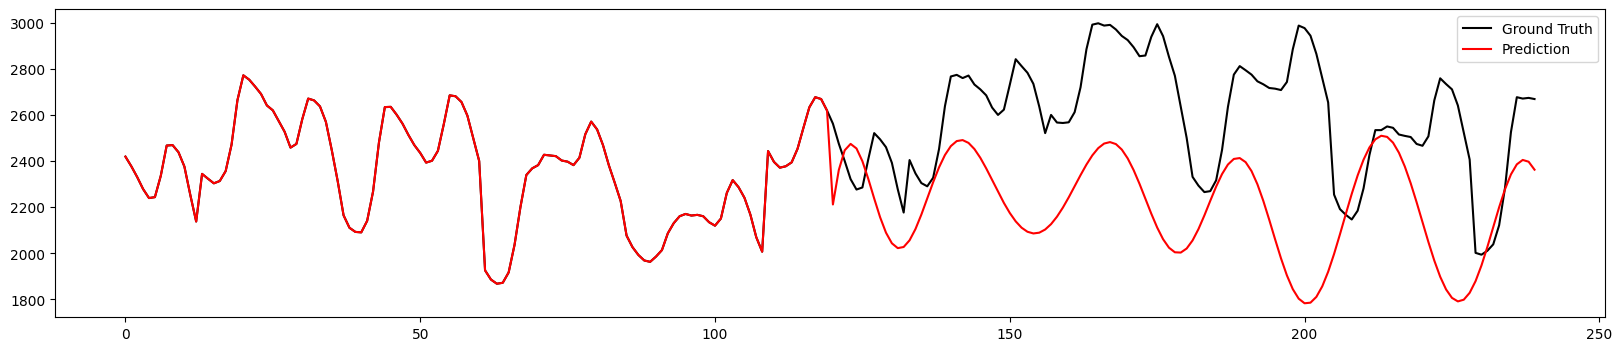

torch.Size([64, 120, 1])
DAYTON_MW


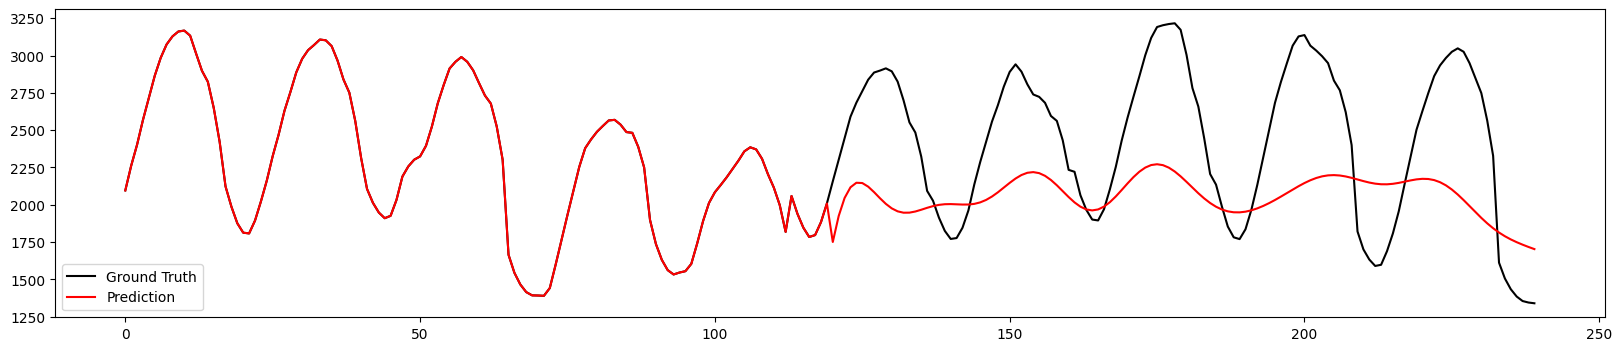

torch.Size([64, 120, 1])
DAYTON_MW


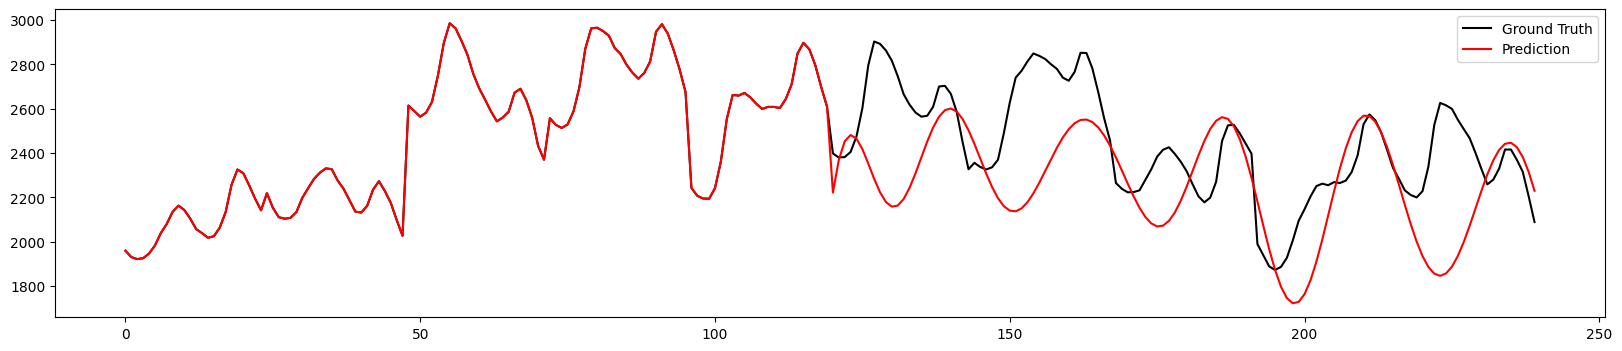

torch.Size([64, 120, 1])
DAYTON_MW


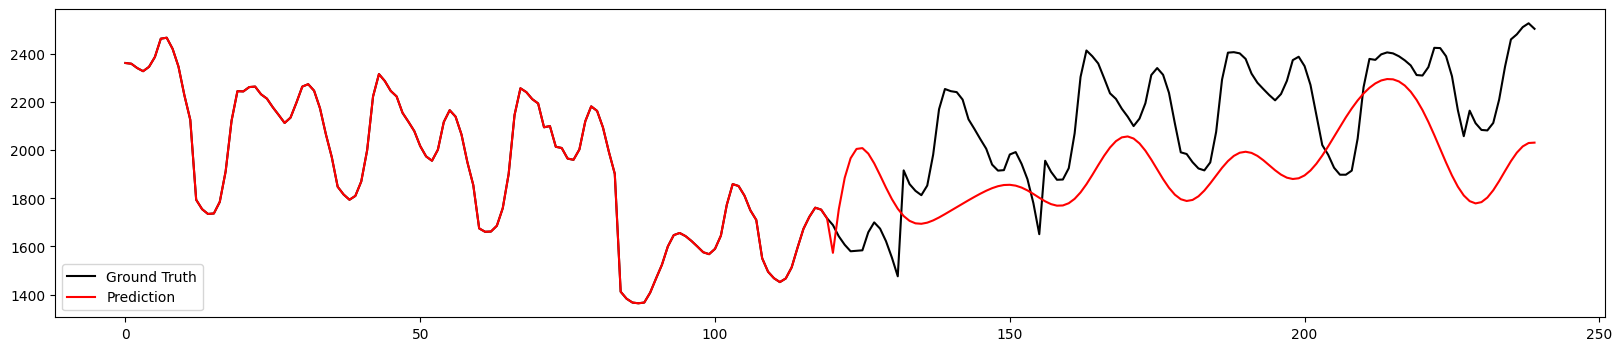

torch.Size([64, 120, 1])
DAYTON_MW


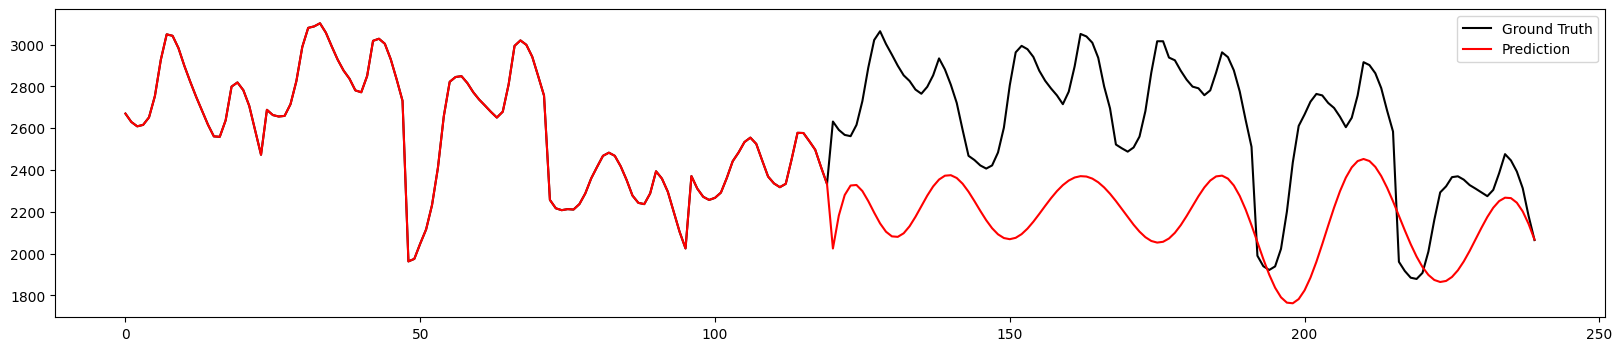

torch.Size([64, 120, 1])
DAYTON_MW


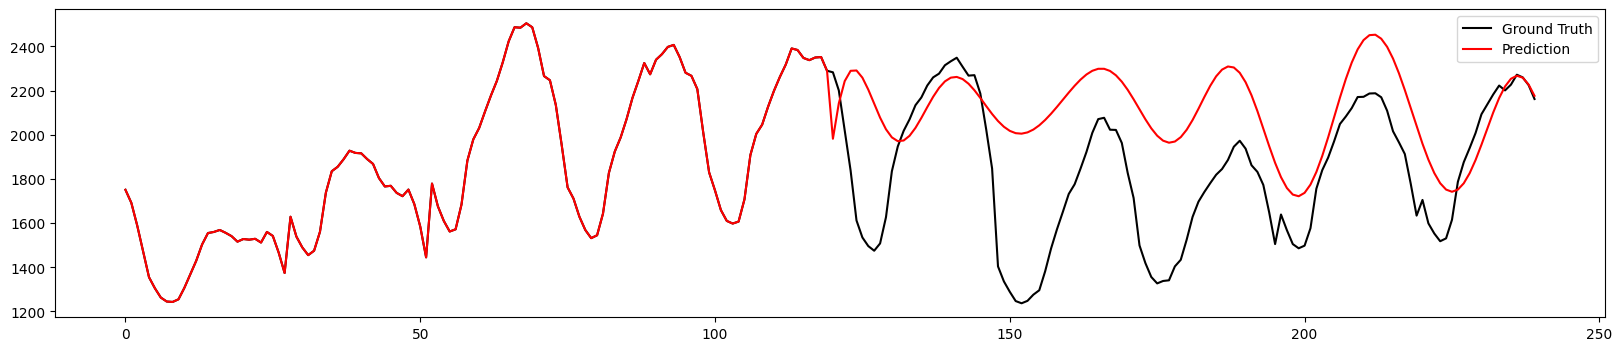

torch.Size([64, 120, 1])
DAYTON_MW


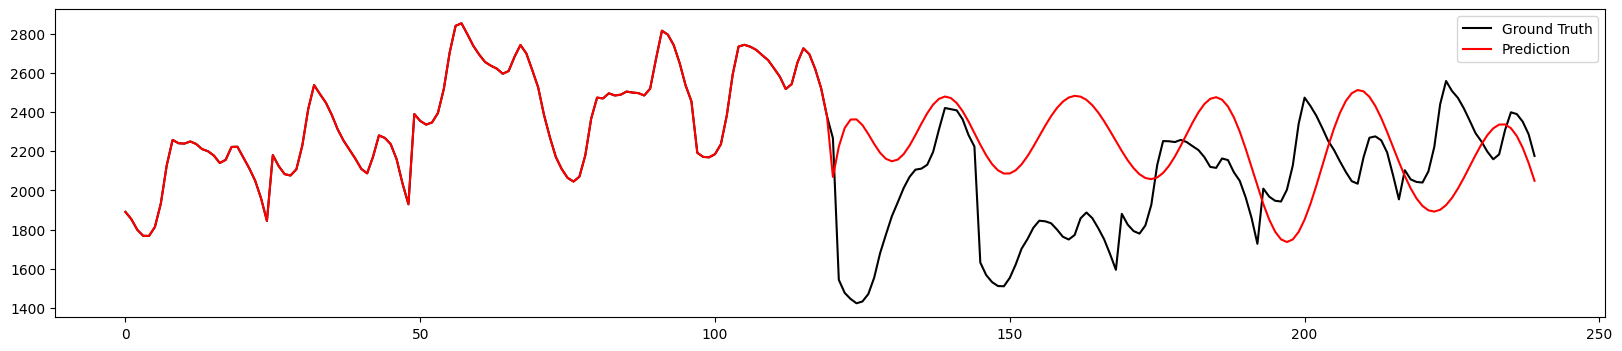

In [447]:
model = torch.load("model.pth")


for _ in range(10):
    model.eval()
    samples, targets = next(val_generator)
    output = make_predictions(model, samples, targets.shape[1])
    print(output.shape)

    plot_predictions(header, samples, targets, output, mean, std)